In [2]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, log_loss
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Permute,multiply,Add,Multiply,BatchNormalization,Dropout, Conv1D, Input, Flatten, Bidirectional, MaxPooling1D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, SpatialDropout1D, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from tensorflow.keras.utils import to_categorical, plot_model
import pydot
import graphviz


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
submission=pd.read_csv('/content/drive/MyDrive/motion/sample_submission.csv')
test=pd.read_csv('/content/drive/MyDrive/motion/test_features.csv')
train_labels=pd.read_csv('/content/drive/MyDrive/motion/train_labels.csv')
train=pd.read_csv('/content/drive/MyDrive/motion/train_features.csv')

In [5]:
train_labels.label_desc.value_counts()
## non-excercise가 대부분인 경우

Non-Exercise                                    1518
Device on Table                                   97
Plank                                             55
Wall Squat                                        48
Jump Rope                                         47
                                                ... 
Triceps Kickback (knee on bench) (right arm)      13
Triceps Kickback (knee on bench) (left arm)       12
Dumbbell Row (knee on bench) (left arm)           12
Arm Band Adjustment                               12
Dumbbell Row (knee on bench) (right arm)          12
Name: label_desc, Length: 61, dtype: int64

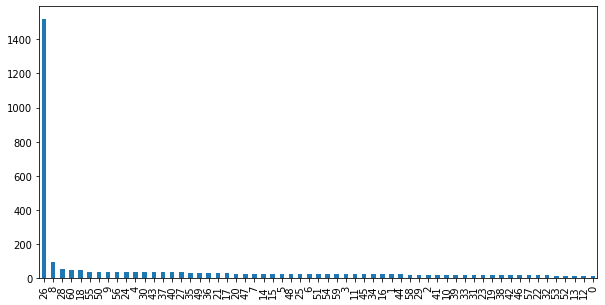

In [6]:
##그림으로 확인
##label이 imbalanced
plt.figure(figsize=(10,5))
train_labels['label'].value_counts().plot(kind='bar')

#### PreProcessing

In [7]:
train.head()
## acc: 3축 가속도계(accelerometer) gy: 3축 자이로스코프(gyroscope)

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [8]:
train.shape ## 8개 column

(1875000, 8)

In [13]:
train['id'].unique().shape ## unique한 id: 3125

(3125,)

In [14]:
train[train['id']==7] ## 7에 해당하는 id 데이터 값 산출

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
4200,7,0,0.103713,-0.831336,0.242183,29.579463,30.649941,27.081531
4201,7,1,-0.006115,-0.803361,0.198072,43.926812,28.957253,37.110641
4202,7,2,-0.004633,-0.751853,0.146588,53.274794,36.461133,58.156605
4203,7,3,0.048017,-0.713709,0.105955,60.976850,59.345987,79.224402
4204,7,4,0.038561,-0.726577,0.110275,64.278783,92.254238,104.648080
...,...,...,...,...,...,...,...,...
4795,7,595,-0.919820,-0.261793,-0.135852,114.075775,-17.260128,-44.608854
4796,7,596,-0.909601,-0.199644,-0.130159,94.752901,-16.557813,-37.065616
4797,7,597,-0.893180,-0.199151,-0.131695,73.654243,-14.923215,-32.315539
4798,7,598,-0.872855,-0.261243,-0.138976,39.692264,-11.147636,-25.407917


In [15]:
act_list=train.iloc[:,2:].columns ## acc-gy column list들 저장
acc_list=['acc_x','acc_y','acc_z'] ## acc list
gy_list=['gy_x','gy_y','gy_z'] ## gy list

In [16]:
# Scaling process
scaler=StandardScaler()
train[act_list]=scaler.fit_transform(train[act_list])
test[act_list]=scaler.transform(test[act_list])

In [17]:
train_labels.head() ## train_labels 데이터 확인

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise


In [22]:
# train, valid split : 약 3125개 label 중 약 15%인 470개를 valid set 으로 분할
def train_valid_split(data):   
  valid_index = random.sample(range(0,3125),470) ## ramdom index 정해놓기
  train_index = list(set(range(0,3125))-set(valid_index)) ## train index set 함수로 나머지 저장 
  X_train=pd.DataFrame()
  X_valid=pd.DataFrame()
  y_train=train_labels.loc[train_index] ## train_labels에 해당하는 값 저장
  y_valid=train_labels.loc[valid_index]
  for i in tqdm(train_index):           ## train_index에 해당하는 id 값을 train데이터와 매칭 시켜 concat
    X_train=pd.concat([X_train,train[train['id']==i]],axis=0)
  for i in tqdm(valid_index):
    X_valid=pd.concat([X_valid,train[train['id']==i]],axis=0)
  return X_train, X_valid, y_train, y_valid

In [23]:
## 위 함수 적용해서 train/valid split
X_train, X_valid, y_train, y_valid=train_valid_split(train)


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

acceleromete, gyroscope sensor feature 분리하는 함수

In [33]:
## ex)
X_ac = [] 
X_ac.append(np.array(train[train['id'] == 7].loc[:,acc_list]))

In [36]:
X_ac

[array([[ 0.77049387, -1.14022973,  0.3946567 ],
        [ 0.61738163, -1.09258897,  0.30129581],
        [ 0.61944783, -1.00487005,  0.19233198],
        ...,
        [-0.61927615, -0.06362362, -0.39664983],
        [-0.59094031, -0.16936599, -0.41205828],
        [-0.56150395, -0.32400833, -0.42100439]])]

In [37]:
X_ac.append(np.array(train[train['id'] == 8].loc[:,acc_list]))

In [38]:
X_ac

[array([[ 0.77049387, -1.14022973,  0.3946567 ],
        [ 0.61738163, -1.09258897,  0.30129581],
        [ 0.61944783, -1.00487005,  0.19233198],
        ...,
        [-0.61927615, -0.06362362, -0.39664983],
        [-0.59094031, -0.16936599, -0.41205828],
        [-0.56150395, -0.32400833, -0.42100439]]),
 array([[-1.02495567,  2.99446697, -1.7014119 ],
        [-0.65900626,  2.70906217, -1.67035825],
        [-0.57534711,  2.62394092, -1.66701087],
        ...,
        [ 0.39945002,  0.06512155,  0.31979205],
        [ 2.43316221,  2.91369686, -0.0990795 ],
        [ 0.50087688,  2.53337903, -0.03744776]])]

In [41]:
np.array(X_ac).shape

(2, 600, 3)

In [45]:
# acceleromete, gyroscope sensor feature split
def sensor_split(data):
  X_acc = [] ##acc 빈 리스트
  X_gy = []  ##gy 빈 리스트
  for i in tqdm(data['id'].unique()):   ## unique한 id 값을 for loop i에 assign
      temp_acc = np.array(data[data['id'] == i].loc[:,acc_list])  ## acc 값 numpy array로 값 가지고
      temp_gy = np.array(data[data['id'] == i].loc[:,gy_list])    ## gy 값 numpy array로 값 가지고
      X_acc.append(temp_acc)  
      X_gy.append(temp_gy)

  X_acc = np.array(X_acc).reshape(-1,600,3)  ## 3차원으로 np 구조 만듬 (unique id갯수,600(id하나당 갇는 600 time),3(feature 갯수))
  X_gy = np.array(X_gy).reshape(-1,600,3)    ## 3차원으로 np 구조 만듬 (unique id갯수,600(id하나당 갇는 600 time),3(feature 갯수))

  return X_acc, X_gy

In [46]:
X_train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413


In [47]:
y_train.head()

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
5,5,26,Non-Exercise


In [50]:
# label 26(Non-exercise)data, 그 외(not Non-exercise)data label data로 분할
X_train_mod=pd.merge(X_train,y_train,how='left',on='id') ## left(X_train) 기준 
X_train_26=X_train_mod[X_train_mod['label']==26] ## label 26 포함된 전체 데이터 셋
X_train_n26=X_train_mod[X_train_mod['label']!=26] ## label 26 제외한 젠체 데이터 셋

In [74]:
X_train_acc_26, X_train_gy_26= sensor_split(X_train_26)
X_train_acc_n26, X_train_gy_n26= sensor_split(X_train_n26)
X_valid_acc, X_valid_gy= sensor_split(X_valid)
X_test_acc, X_test_gy= sensor_split(test)

  0%|          | 0/1302 [00:00<?, ?it/s]

  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

In [75]:
X_train_acc_26.shape ## shape: (1287, 600, 3)

(1302, 600, 3)

In [76]:
X_train_gy_26.shape

(1302, 600, 3)

In [77]:
X_train_acc_n26.shape ## shape: (5472, 600, 3)

(1353, 600, 3)

In [78]:
X_train_gy_n26.shape 

(1353, 600, 3)

### *Augmentation*

##### -non26에 한해서만 augmentation 적용:😊

In [79]:
# Rolling
def aug(data, uid, shift):
    shift_data = np.roll(data[uid], shift, axis=0)
    return shift_data
def roll_aug(data):
  aug_data=[]
  for i in range(data.shape[0]):
    temp=list((aug(data,i,int(random.random()*600))))
    aug_data.append(temp)
  return np.array(aug_data)
# Jitter
sigma=0.05
def Jitter(X, sigma):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise
# Scaling
def Scaling(X, sigma):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise
# Magnitude Warping
sigma = 0.2
knot = 4
def GenerateRandomCurves(X, sigma, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()
def MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)
# Time Warping
sigma = 0.2
knot = 4
def DistortTimesteps(X, sigma):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum
def TimeWarp(X, sigma):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new
# Cropping
def crop(X_acc,X_gy,y_data,data_length,data_interval,time_step,start_index,history_size,y=True):
  X_train_seq_acc=[]
  X_train_seq_gy=[]
  y_train_seq=[]
  start_index=start_index+history_size
  
  if y==True:
    for i in tqdm(range(X_acc.shape[0])):
      for j in range(start_index,data_length+1,data_interval):
        index=range(j-history_size,j,time_step)
        X_train_seq_acc.append(list(X_acc[i,index,:]))
        X_train_seq_gy.append(list(X_gy[i,index,:]))
        y_train_seq.append(y_data[i])
    return np.array(X_train_seq_acc), np.array(X_train_seq_gy), np.array(y_train_seq)
  
  else:
    for i in tqdm(range(X_acc.shape[0])):
      for j in range(start_index,data_length+1,data_interval):
        index=range(j-history_size,j,time_step)
        X_train_seq_acc.append(list(X_acc[i,index,:]))
        X_train_seq_gy.append(list(X_gy[i,index,:]))
    return np.array(X_train_seq_acc), np.array(X_train_seq_gy)

In [80]:
def ts_aug(data, method,sigma):
  new_data=[]
  for i in range(data.shape[0]):
    temp=list(method(data[i], sigma))
    new_data.append(temp)
  return np.array(new_data)

In [81]:
X_train_acc_n26_rolling = roll_aug(X_train_acc_n26)
X_train_acc_n26_timewarp = ts_aug(X_train_acc_n26, TimeWarp,0.2)
X_train_acc_n26_magwarp = ts_aug(X_train_acc_n26, MagWarp,0.2)

X_train_gy_n26_rolling = roll_aug(X_train_gy_n26)
X_train_gy_n26_timewarp = ts_aug(X_train_gy_n26, TimeWarp,0.2)
X_train_gy_n26_magwarp = ts_aug(X_train_gy_n26, MagWarp,0.2)

In [82]:
X_train_acc_n26_rolling.shape

(1353, 600, 3)

In [83]:
X_train_acc_n26_timewarp.shape

(1353, 600, 3)

In [84]:
X_train_acc_n26_magwarp.shape

(1353, 600, 3)

In [85]:
y_train.head()

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
5,5,26,Non-Exercise


In [88]:
###augmentation 결과 값 결합 (기존 값+rolling,timewarp,magwarp)
X_train_acc_n26=np.append(X_train_acc_n26,X_train_acc_n26_rolling, axis=0)
X_train_acc_n26=np.append(X_train_acc_n26,X_train_acc_n26_timewarp, axis=0)
X_train_acc_n26=np.append(X_train_acc_n26,X_train_acc_n26_magwarp, axis=0)
X_train_acc_n26.shape

(5412, 600, 3)

In [89]:
X_train_gy_n26=np.append(X_train_gy_n26,X_train_gy_n26_rolling, axis=0)
X_train_gy_n26=np.append(X_train_gy_n26,X_train_gy_n26_timewarp, axis=0)
X_train_gy_n26=np.append(X_train_gy_n26,X_train_gy_n26_magwarp, axis=0)
X_train_gy_n26.shape

(5412, 600, 3)

In [90]:
X_train_acc=np.append(X_train_acc_n26,X_train_acc_26, axis=0) ## augment된 n26과 기존 26결합
X_train_acc.shape

(6714, 600, 3)

In [91]:
X_train_gy=np.append(X_train_gy_n26,X_train_gy_26, axis=0) ## augment된 n26과 기존 26결합
X_train_gy.shape

(6714, 600, 3)

In [86]:
## label select
y_train_26=y_train[y_train['label']==26]['label'] ## label이 26인 label만 저장
y_train_n26=y_train[y_train['label']!=26]['label'] ## label이 n26인 label만 저장

In [87]:
y_train_26

3       26
4       26
5       26
6       26
7       26
        ..
3113    26
3114    26
3116    26
3121    26
3123    26
Name: label, Length: 1302, dtype: int64

In [93]:
## augmentation 된 x와 일치하게 non26 label 추가 
y_train_total = np.append(y_train_n26,y_train_n26,axis=0) 
y_train_total = np.append(y_train_total,y_train_n26,axis=0)
y_train_total = np.append(y_train_total,y_train_n26,axis=0)
y_train_total.shape 

(5412,)

In [96]:
y_train = np.append(y_train_total,y_train_26,axis=0) ###순서(n26)(5412)-> (26)(1302)

Label에 대한 One hot encoding (to_categorical) 

In [99]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid['label'])

In [100]:
sequence_length=X_train_acc.shape[1] ##shape[1]은 ID하나당 가지는 time
X_train_acc.shape

(6714, 600, 3)

In [106]:
# Shuffle
s = np.arange(X_train_acc.shape[0])
np.random.shuffle(s)## 0-6713 random shuffle
X_train_acc = X_train_acc[s]
X_train_gy = X_train_gy[s]
y_train = y_train[s]

##### *변수 정리* 😊
X_train_acc: acc해당 train x값

X_train_gy: gy해당 train x값

y_train: label encoding 후 label y 값

### Deep learning Model (1d conv+LSTM)

In [107]:
num=128
kernel_size=2
strides_size=1
model_1_input = Input(shape=(sequence_length,3)) ## (shape=(600,3)) 하나의 id당 갖는 time:600, feature:3개
model_1 = Conv1D(num,kernel_size,strides_size,activation=None)(model_1_input)
model_1 = BatchNormalization()(model_1)
model_1 = Activation('relu')(model_1)
model_1 = MaxPooling1D(2)(model_1)
model_1 = Conv1D(2*num,kernel_size,strides_size,activation=None)(model_1)
model_1 = BatchNormalization()(model_1)
model_1 = Activation('relu')(model_1)
model_1 = MaxPooling1D(2)(model_1)
model_1 = Conv1D(3*num,kernel_size,strides_size,activation=None)(model_1)
model_1 = BatchNormalization()(model_1)
model_1 = Activation('relu')(model_1)
model_1 = MaxPooling1D(2)(model_1)
model_1 = LSTM(int(num/2))(model_1)
model_1 = Model(inputs=model_1_input, outputs = model_1)

model_2_input = Input(shape=(sequence_length,3)) ## (shape=(600,3)) 하나의 id당 갖는 time:600, feature:3개
model_2 = Conv1D(num,kernel_size,strides_size,activation=None)(model_2_input)
model_2 = BatchNormalization()(model_2)
model_2 = Activation('relu')(model_2)
model_2 = MaxPooling1D(2)(model_2)
model_2 = Conv1D(2*num,kernel_size,strides_size,activation=None)(model_2)
model_2 = BatchNormalization()(model_2)
model_2 = Activation('relu')(model_2)
model_2 = MaxPooling1D(2)(model_2)
model_2 = Conv1D(3*num,kernel_size,strides_size,activation=None)(model_2)
model_2 = BatchNormalization()(model_2)
model_2 = Activation('relu')(model_2)
model_2 = MaxPooling1D(2)(model_2)
model_2 = LSTM(int(num/2))(model_2)
model_2 = Model(inputs=model_2_input, outputs = model_2)

combinedInput = concatenate([model_1.output, model_2.output]) ## model1, model2 concatenate
x = Flatten()(combinedInput)
x = Dense(61, activation="softmax")(x)
final_model = Model(inputs=[model_1.input, model_2.input], outputs=x)
final_model.summary()
final_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = final_model.fit(x=[X_train_acc,X_train_gy], y=y_train, epochs=50, callbacks=[es, mc],
                          validation_data=([X_valid_acc, X_valid_gy], y_valid), batch_size=128)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 3)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 600, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 599, 128)     896         ['input_1[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 599, 128)     896         ['input_2[0][0]']                
                                                                                            

##### Visualization 
Epoch와 오차(Loss)간 관게 

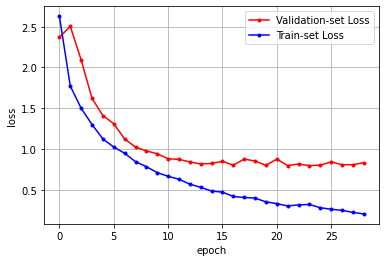

In [118]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

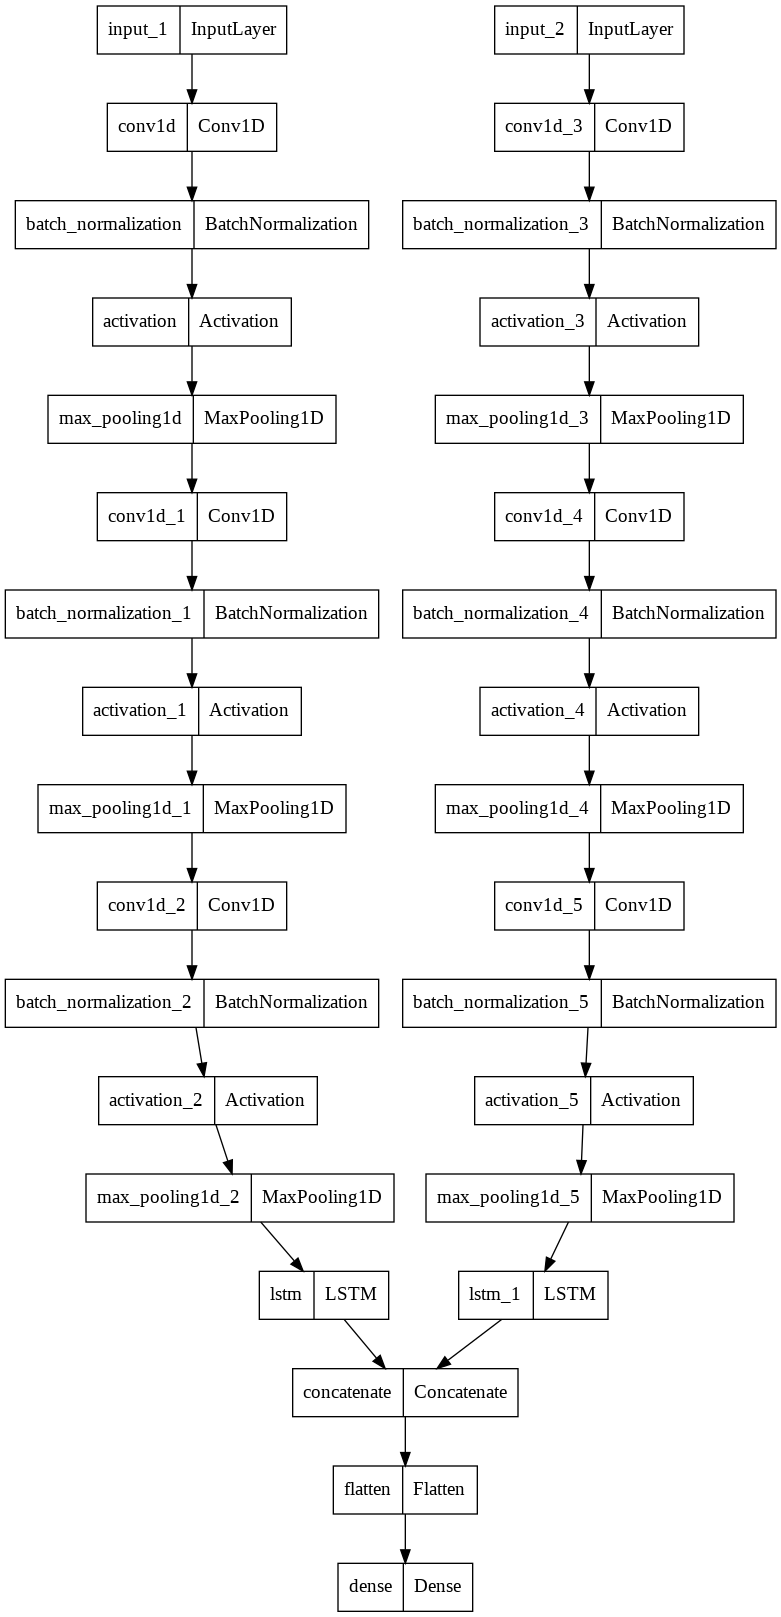

In [110]:
plot_model(final_model, to_file='/content/model.png') ## model structure

In [111]:
final_model.load_weights('/content/best_model.h5') ##best_model weight load
y_pred=final_model.predict([X_test_acc,X_test_gy])

Text(0.5, 0, 'time')

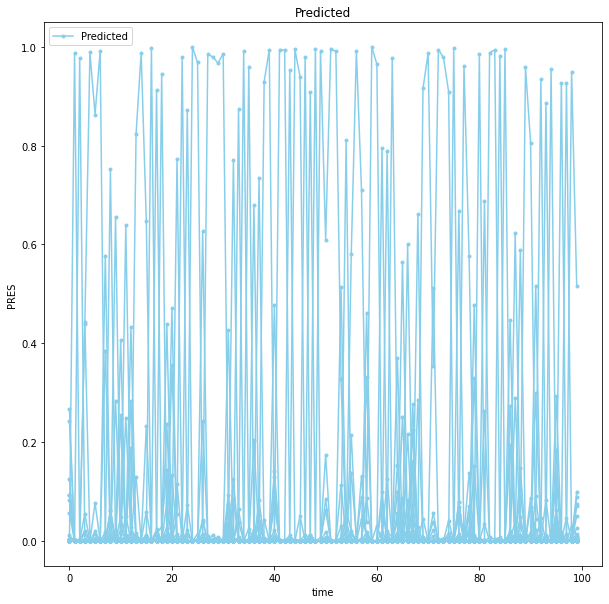

In [115]:
#plot the 100 actual and predicted values of PRES.
plt.figure(figsize=(10, 10))
#plt.plot(range(100), df_val['pm2.5'].loc[7:106], linestyle='-', marker='*', color='r') 
plt.plot(range(100), y_pred[:100], linestyle='-', marker='.', color='skyblue')
plt.legend(['Predicted'], loc=2)
plt.title('Predicted')
plt.ylabel('PRES')
plt.xlabel('time')